### Imports and fetching data

In [5]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.metrics import adjusted_rand_score, v_measure_score
from sklearn.model_selection import ParameterGrid
import pandas as pd
import numpy as np

X, y = fetch_openml(name='mnist_784',return_X_y=True, as_frame=False)

### Visualising sampled images and labels

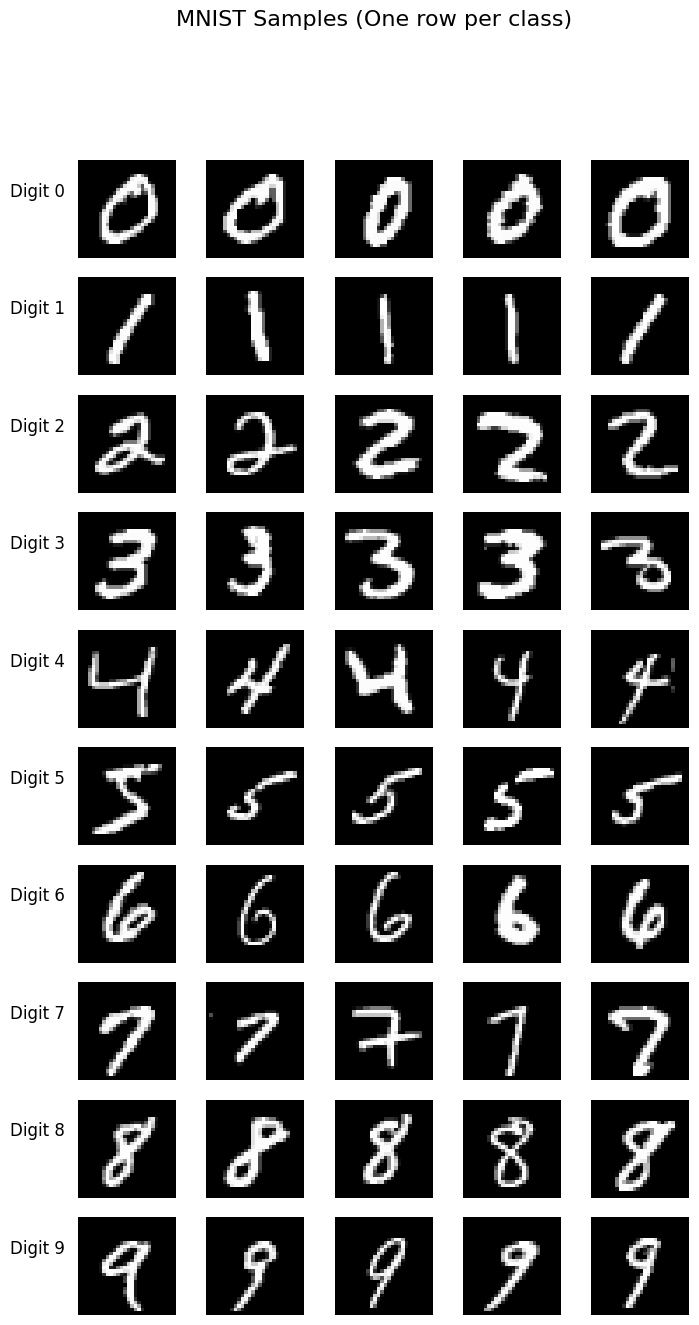

In [6]:
fig, axes = plt.subplots(10, 5, figsize=(8, 15))

# y comes as strings from openml ('0', '1', ...)
classes = sorted(np.unique(y))

for i, cls in enumerate(classes):
    # Get indices of all images belonging to this class
    idxs = np.where(y == cls)[0]
    
    # Take the first 5 examples
    for j in range(5):
        ax = axes[i, j]
        if j < len(idxs):
            # Reshape flat 784 vector to 28x28 image
            img = X[idxs[j]].reshape(28, 28)
            ax.imshow(img, cmap='gray')
        ax.axis('off')
        # Add label to the left-most image of each row
        if j == 0:
            ax.text(-20, 10, f"Digit {cls}", fontsize=12)
plt.suptitle("MNIST Samples (One row per class)", fontsize=16)
plt.show()

### Scaling the data to 0-1 and performing PCA
Only fit PCA on the training data to prevent information leakage


In [7]:
X_scaled = X / 255.0
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

pca = PCA(n_components=80)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

### K-Means clustering

#### Choosing hyperparameters
To systematically find the best combination of hyperparameters for K-Means, I perform a Grid Search.\
The MNIST dataset has ground truth labels, so I can use ARI and homogeneity metrics to evaluate the model created with each set of hyperparameters\
I have explored ... hyperparameters. This is because...

In [ ]:
param_grid = {
    'n_clusters': [8, 10, 12, 15], 
    'n_init': [10, 20, 30],
}

results = []
print(f"Starting Grid Search with {len(ParameterGrid(param_grid))} combinations...")
for params in ParameterGrid(param_grid):
    
    # Initialize and fit
    kmeans = KMeans(**params)
    kmeans.fit(X_train_reduced)
    
    # score the model
    y_pred = kmeans.predict(X_test_reduced)
    ari_score = adjusted_rand_score(y_test, y_pred)
    v_score = v_measure_score(y_test, y_pred)
    avg_score = (v_score + ari_score) / 2
    
    # Store results
    result_entry = params.copy()
    result_entry['ari_score'] = ari_score
    result_entry['v_score'] = v_score
    result_entry['avg_score'] = avg_score
    results.append(result_entry)
    
    print(f"Finished params: {params} | Adjusted Rand Score: {ari_score:.2f} | V Score {v_score:.2f} | Average Score {avg_score:.2f}")

# 4. Convert to DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Sort by Silhouette Score (descending)
best_results = results_df.sort_values(by='avg_score', ascending=False)

print("\n--- Top 5 Configurations ---")
print(best_results.head(5))

Starting Grid Search with 12 combinations...
Finished params: {'n_clusters': 8, 'n_init': 10} | Adjusted Rand Score: 0.40 | V Score 0.51 | Average Score 0.45
Finished params: {'n_clusters': 8, 'n_init': 20} | Adjusted Rand Score: 0.39 | V Score 0.51 | Average Score 0.45
Finished params: {'n_clusters': 8, 'n_init': 30} | Adjusted Rand Score: 0.39 | V Score 0.51 | Average Score 0.45
Finished params: {'n_clusters': 10, 'n_init': 10} | Adjusted Rand Score: 0.37 | V Score 0.48 | Average Score 0.42
Finished params: {'n_clusters': 10, 'n_init': 20} | Adjusted Rand Score: 0.37 | V Score 0.50 | Average Score 0.43
Finished params: {'n_clusters': 10, 'n_init': 30} | Adjusted Rand Score: 0.37 | V Score 0.50 | Average Score 0.43
Finished params: {'n_clusters': 12, 'n_init': 10} | Adjusted Rand Score: 0.35 | V Score 0.50 | Average Score 0.43
Finished params: {'n_clusters': 12, 'n_init': 20} | Adjusted Rand Score: 0.35 | V Score 0.50 | Average Score 0.43
Finished params: {'n_clusters': 12, 'n_init': 

#### Visualising results

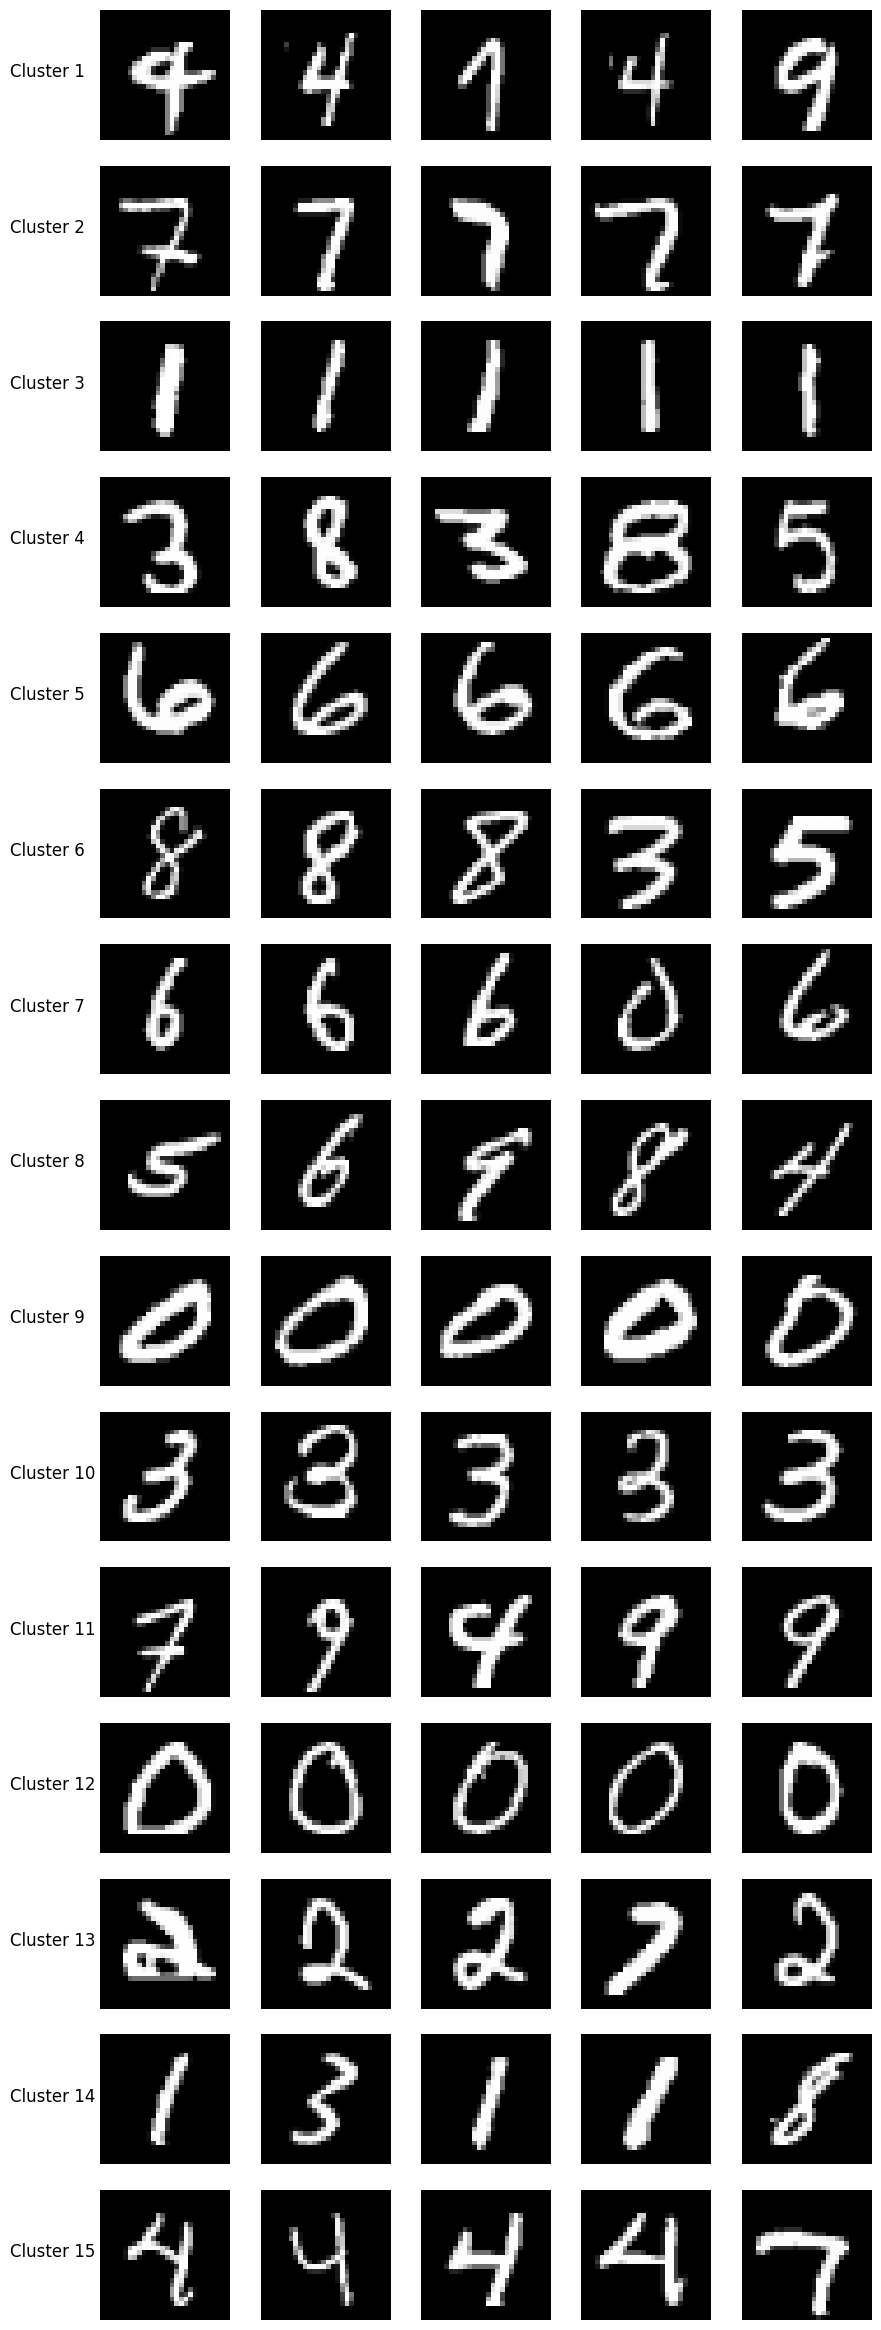

In [13]:
# 1. Retrain with the best parameters found above
best_params = best_results.iloc[0].to_dict()
# Explicitly convert hyperparams back to int
best_params['n_clusters'] = int(best_params['n_clusters'])
best_params['n_init'] = int(best_params['n_init'])
# Remove scores from the dict to pass it into the model
del best_params['ari_score']
del best_params['v_score']
del best_params['avg_score']

best_kmeans = KMeans(**best_params)
best_kmeans.fit(X_train_reduced)
cluster_labels = best_kmeans.predict(X_train_reduced)

fig, axes = plt.subplots(best_params['n_clusters'], 5, figsize=(10, 2 * best_params['n_clusters']))
for cluster_id in range(best_params['n_clusters']):
    # Find indices of all images assigned to this specific cluster
    indices = np.where(cluster_labels == cluster_id)[0]
    # Select random samples from this cluster (or the first 5)
    # We use a try/except in case a cluster has fewer than 5 items
    try:
        selected_indices = np.random.choice(indices, 5, replace=False)
    except ValueError:
        selected_indices = indices[:5] # Take what is available
        
    for i, idx in enumerate(selected_indices):
        ax = axes[cluster_id, i]
        
        # Reshape the original flat pixel vector (784,) into a 28x28 image
        image = X_train[idx].reshape(28, 28)
        
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        
        # Label the first image of each row with the Cluster ID
        if i == 0:
            ax.text(-20, 14, f"Cluster {cluster_id + 1}", fontsize=12)

plt.show()

### Gaussian Mixture Model
#### Choosing hyperparameters

In [14]:


param_grid = {
    'n_components': [8, 10, 12, 15], 
    'covariance_type': ['full', 'tied', 'diag']
}
results = []
print(f"Starting Grid Search with {len(ParameterGrid(param_grid))} combinations...")
for params in ParameterGrid(param_grid):
    
    # Initialize and Fit
    gmm = GaussianMixture(**params)
    gmm.fit(X_train_reduced)

    
   # score the model
    y_pred = gmm.predict(X_test_reduced)
    ari_score = adjusted_rand_score(y_test, y_pred)
    v_score = v_measure_score(y_test, y_pred)
    avg_score = (v_score + ari_score) / 2
    
    # Store results
    result_entry = params.copy()
    result_entry['ari_score'] = ari_score
    result_entry['v_score'] = v_score
    result_entry['avg_score'] = avg_score
    results.append(result_entry)
    
    print(f"Finished params: {params} | Adjusted Rand Score: {ari_score:.2f} | Homogeneity Score {v_score:.2f} | Average Score {avg_score:.2f}")

# 4. Convert to DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Sort by Silhouette Score (descending)
best_results = results_df.sort_values(by='avg_score', ascending=False)

print("\n--- Top 5 Configurations ---")
print(best_results.head(5))

Starting Grid Search with 12 combinations...
Finished params: {'covariance_type': 'full', 'n_components': 8} | Adjusted Rand Score: 0.31 | Homogeneity Score 0.53 | Average Score 0.42
Finished params: {'covariance_type': 'full', 'n_components': 10} | Adjusted Rand Score: 0.40 | Homogeneity Score 0.57 | Average Score 0.48
Finished params: {'covariance_type': 'full', 'n_components': 12} | Adjusted Rand Score: 0.37 | Homogeneity Score 0.58 | Average Score 0.47


/home/asher/.local/lib/python3.13/site-packages/sklearn/mixture/_base.py:275: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


Finished params: {'covariance_type': 'full', 'n_components': 15} | Adjusted Rand Score: 0.36 | Homogeneity Score 0.57 | Average Score 0.47
Finished params: {'covariance_type': 'tied', 'n_components': 8} | Adjusted Rand Score: 0.19 | Homogeneity Score 0.41 | Average Score 0.30
Finished params: {'covariance_type': 'tied', 'n_components': 10} | Adjusted Rand Score: 0.31 | Homogeneity Score 0.47 | Average Score 0.39
Finished params: {'covariance_type': 'tied', 'n_components': 12} | Adjusted Rand Score: 0.24 | Homogeneity Score 0.43 | Average Score 0.34
Finished params: {'covariance_type': 'tied', 'n_components': 15} | Adjusted Rand Score: 0.26 | Homogeneity Score 0.45 | Average Score 0.36
Finished params: {'covariance_type': 'diag', 'n_components': 8} | Adjusted Rand Score: 0.26 | Homogeneity Score 0.47 | Average Score 0.36
Finished params: {'covariance_type': 'diag', 'n_components': 10} | Adjusted Rand Score: 0.22 | Homogeneity Score 0.46 | Average Score 0.34
Finished params: {'covariance

#### Visualising results

Since I used PCA, I use `pca.inverse_transform` to turn the 200-dimension centroids back into 784-dimension (28x28) images.

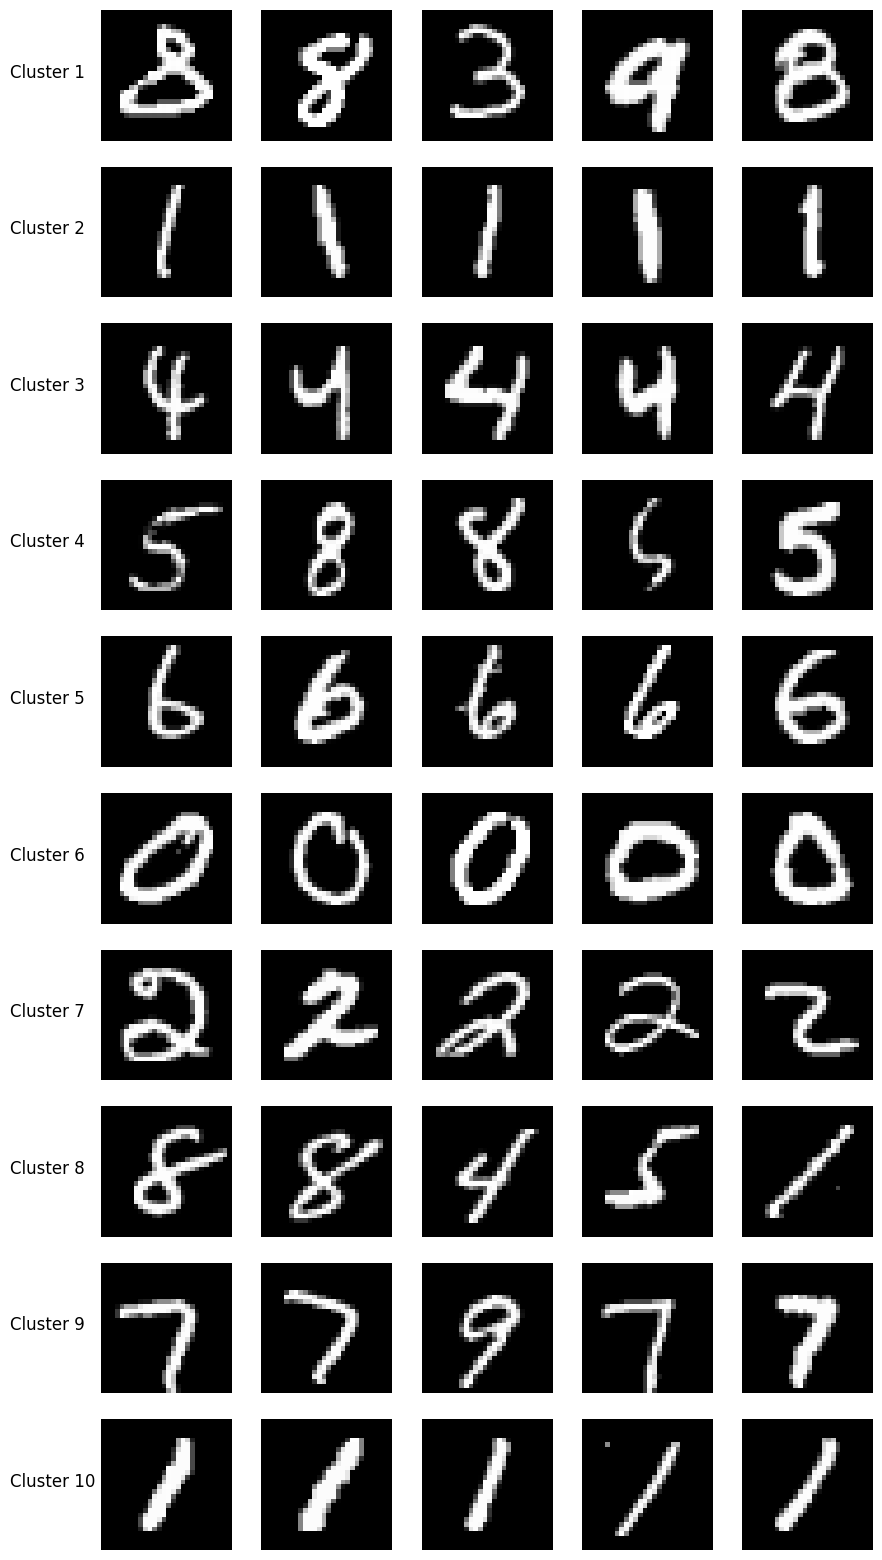

In [15]:
# 1. Retrain with the best parameters found above
best_params = best_results.iloc[0].to_dict()
# Remove scores from the dict to pass it into the model
del best_params['ari_score']
del best_params['v_score']
del best_params['avg_score']

best_gmm = GaussianMixture(**best_params)
best_gmm.fit(X_train_reduced)
cluster_labels = best_gmm.predict(X_train_reduced)

fig, axes = plt.subplots(best_params['n_components'], 5, figsize=(10, 2 * best_params['n_components']))
for cluster_id in range(best_params['n_components']):
    # Find indices of all images assigned to this specific cluster
    indices = np.where(cluster_labels == cluster_id)[0]
    # Select random samples from this cluster (or the first 5)
    # We use a try/except in case a cluster has fewer than 5 items
    try:
        selected_indices = np.random.choice(indices, 5, replace=False)
    except ValueError:
        selected_indices = indices[:5] # Take what is available
        
    for i, idx in enumerate(selected_indices):
        ax = axes[cluster_id, i]
        
        # Reshape the original flat pixel vector (784,) into a 28x28 image
        image = X_train[idx].reshape(28, 28)
        
        ax.imshow(image, cmap='gray')
        ax.axis('off')
        
        # Label the first image of each row with the Cluster ID
        if i == 0:
            ax.text(-20, 14, f"Cluster {cluster_id + 1}", fontsize=12)

plt.show()